In [1]:
from src.data.load_data import *
from src.models.util_model import *
from src.data.preprocess import *
from src.data.postprocess import *
from src.data.util import *
from pathlib import Path

In [2]:
dataset_path = Path("data/raw")
target_path = dataset_path / "trans021-1.png"
target_image = read_image(target_path)

In [3]:
section_dict = detect_section(target_image)


0: 640x480 3 sections, 875.9ms
Speed: 2.6ms preprocess, 875.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


In [4]:
processed_sections = preprocess(section_dict)

In [5]:
text_dict = images_to_texts(processed_sections)

In [6]:
courses_df = make_course(text_dict)

Error from get_courseID
33101: ศิลปะ 5                      05    4
Error from get_courseID
31202: เทเบิลเทนนิส                                   05       4


In [7]:
courses_df

,ocr,numeric,section,id,name,unit,grade
0,ค33101: คณิตศาสตร์ 5 10 4,1 4,000,ค33101,คณิตศาสตร์ 5,1.0,4.0
1,ว30105: วิทยาศาสตร์ 5 10 4,1 4,001,ว30105,วิทยาศาสตร์ 5,1.0,4.0
2,ส33101: สังคมศึกษา ศาสนาและวัฒนธรรม 5 ...,1 4,002,ส33101,สังคมศึกษา,1.0,4.0
3,พ33101: สุขศึกษาและพลศึกษา 5 05 4,5 4,003,พ33101,สุขศึกษาและพลศึกษา 5,0.5,4.0
4,33101: ศิลปะ 5 05 4,5 4,004,999,ศิลปะ 5,0.5,4.0
...,...,...,...,...,...,...,...
113,ว30268: โครงงาน 1 10 4,1 4,237,ว30268,โครงงาน 1,1.0,4.0
114,ว30290: เทคนิคปฏิบัติการพื้นฐานทางวิทยาศาสตร์ ...,1 4,238,ว30290,เทคนิคปฏิบัติการพื้นฐานทางวิทยาศาสตร์ 1,1.0,4.0
115,ว30291: เทคนิคปฏิบัติการพื้นฐานทางวิทยาศาสตร์ ...,1 4,239,ว30291,เทคนิคปฏิบัติการพื้นฐานทางวิทยาศาสตร์ 2,1.0,4.0
116,อ30204: การเขียนรายงานการวิจัยภาษาอังกฤษ ...,1 4,240,อ30204,การเขียนรายงานการวิจัยภาษาอังกฤษ,1.0,4.0


In [8]:
error_df = get_error(courses_df).reset_index(drop=True)
error_df

,ocr,numeric,section,id,name,unit,grade
0,33101: ศิลปะ 5 05 4,5 4,004,999,ศิลปะ 5,0.5,4.0
1,ว33202: พิสิกส์ 6 ...,15,029,ว33202,พิสิกส์ 6,999.0,999.0
2,31202: เทเบิลเทนนิส ...,5 4,134,999,เทเบิลเทนนิส,0.5,4.0
3,อ31204: ภาษาอังกฤษฟัง-พูด 2 ...,,135,อ31204,ภาษาอังกฤษฟัง,999.0,999.0
4,ล32102: ประวัติศาสตร์ 3 ...,5,203,ส32102,ประวัติศาสตร์ 3,999.0,999.0


In [18]:
error_df

,ocr,numeric,section,id,name,unit,grade
0,33101: ศิลปะ 5 05 4,5 4,004,999,ศิลปะ 5,0.5,4.0
1,ว33202: พิสิกส์ 6 ...,15,029,ว33202,พิสิกส์ 6,999.0,999.0
2,31202: เทเบิลเทนนิส ...,5 4,134,999,เทเบิลเทนนิส,0.5,4.0
3,อ31204: ภาษาอังกฤษฟัง-พูด 2 ...,,135,อ31204,ภาษาอังกฤษฟัง,999.0,999.0


In [31]:
for error_record in error_df.values:
    print(error_record)
    section_idx = error_record[2]
    section_image = processed_sections[int(section_idx[0])]

    pads = [12, 10, 8, 6, 4]
    for pad in pads:
        focus_image = focus_subject(section_image, int(section_idx[1:]), pad)
        focus_text = images_to_texts({section_idx[0]: focus_image})
        focus_df = make_course(focus_text)
        focus_df = get_non_error(focus_df)
        print(focus_df['ocr'].to_list())
        is_help = True if (error_record[3] in focus_df['id'].to_list()) else False
        if is_help:
            correct_record = focus_df.loc[focus_df['id'] == error_record[3]]
            correct_record = correct_record.reset_index(drop=True)
            correct_record['section'] =  section_idx
            courses_df[courses_df['id'] == correct_record['id'][0]] = correct_record.loc[0].to_list()
            break
    error_df = get_error(courses_df).reset_index(drop=True)

['33101: ศิลปะ 5                      05    4' '5    4' '004' '999' 'ศิลปะ 5' 0.5 4.0]


In [32]:
focus_text

{'0': ''}

In [25]:
error_df['ocr'][3]

'อ31204: ภาษาอังกฤษฟัง-พูด 2                             ย'

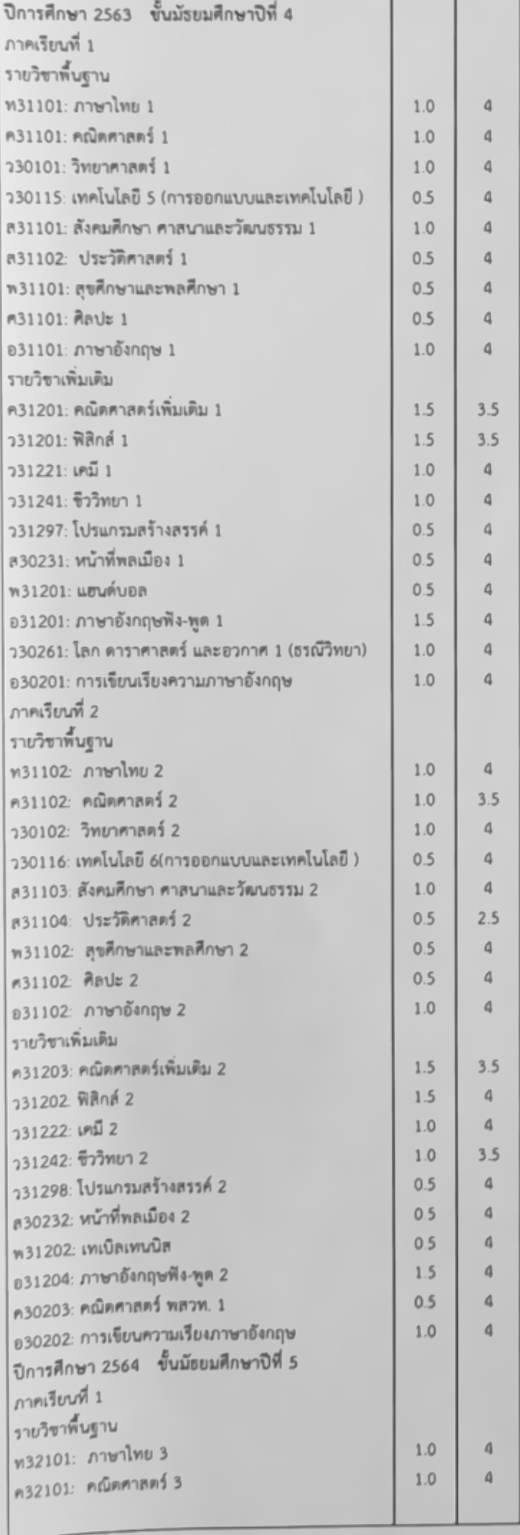

In [21]:
processed_sections[1]